In [54]:
from diffusers import UNet2DConditionModel, AutoencoderKL, PNDMScheduler
from transformers import T5EncoderModel, T5TokenizerFast
import torch
import os
import numpy as np
import librosa
from tqdm import tqdm
import soundfile as sf
import torchaudio
import matplotlib.pyplot as plt
%matplotlib inline

In [101]:
# MODEL_PATH = "/blob/v-yuancwang/AudioEditingModel/Diffusion_SG/checkpoint-350000"
MODEL_PATH = "/blob/v-yuancwang/AudioEditingModel/Diffusion_SE/checkpoint-100000"
CFG = 4.0
TORCH_DEVICE = "cuda:3"
# SAVE_MEL_PATH = "/blob/v-yuancwang/audio_editing_test/baseline/replacement/0/mel"
SAVE_MEL_PATH = "/blob/v-yuancwang/audio_editing_test/replacement/mel"
# STRENGTH = 0.5
STRENGTH = 1.0

In [102]:
model_path = MODEL_PATH
vae = AutoencoderKL.from_pretrained(model_path, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(model_path, subfolder="unet")
tokenizer = T5TokenizerFast.from_pretrained(model_path, subfolder="tokenizer")
text_encoder = T5EncoderModel.from_pretrained(model_path, subfolder="text_encoder")

In [ ]:
vae.to(TORCH_DEVICE)
text_encoder.to(TORCH_DEVICE)
unet.to(TORCH_DEVICE)
vae.requires_grad_(False)
unet.requires_grad_(False)
text_encoder.requires_grad_(False)

In [104]:
with open("/home/v-yuancwang/AudioEditing/test_baseline/replacement.txt", "r") as f:
    lines = f.readlines()

In [105]:
for line in lines[:1]:
    mel_src, mel_tgt, edit_text, gen_text = line.replace("\n", "").split("   ")
    file_name = mel_tgt.split("/")[-1].replace(".wav", "")
    mel_src = np.load(mel_src.replace(".wav", ".npy").replace("/wav/", "/mel/"))
    mel_tgt = np.load(mel_tgt.replace(".wav", ".npy").replace("/wav/", "/mel/"))
    # text = gen_text
    ######
    text = edit_text
    print(text)
    prompt = [text]
    text_input = tokenizer(prompt, max_length=tokenizer.model_max_length, truncation=True, padding="do_not_pad", return_tensors="pt")
    text_embeddings = text_encoder(text_input.input_ids.to(TORCH_DEVICE))[0]
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
        [""] * 1, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(TORCH_DEVICE))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    num_inference_steps = 100
    scheduler = PNDMScheduler.from_pretrained(model_path, subfolder="scheduler")
    scheduler.set_timesteps(num_inference_steps)
    latents_src = torch.Tensor(np.array([[mel_src]])).to(TORCH_DEVICE)
    latents_src = vae.encode(latents_src).latent_dist.sample()
    guidance_scale = CFG
    strength = STRENGTH

    noise = torch.randn_like(latents_src).to(TORCH_DEVICE)

    init_timestep = min(int(num_inference_steps * strength), num_inference_steps)
    t_start = max(num_inference_steps - init_timestep, 0)

    # latents = scheduler.add_noise(latents_src, noise, scheduler.timesteps[t_start: t_start+1])
    ######
    latents = torch.randn((1, 4, 10, 78)).to(TORCH_DEVICE)
    latents_src_input = torch.cat([latents_src] * 2)


    for t in tqdm(scheduler.timesteps[t_start:]):

        
        latent_model_input = torch.cat([latents] * 2)

        latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

        # predict the noise residual
        with torch.no_grad():
            ######
            noise_pred = unet(torch.cat((latent_model_input, latents_src_input), dim=1), t, encoder_hidden_states=text_embeddings).sample
            # noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
                
        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        # latents_predict = scheduler.step(noise_pred, t, latents).prev_sample
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    latents_out = latents

    with torch.no_grad():
        res = vae.decode(latents_out).sample
    res = res.cpu().numpy()[0,0,:,:]

    np.save(os.path.join(SAVE_MEL_PATH, file_name + ".npy"), res)

Replace: wind instrument and woodwind instrument to gasp


100%|██████████| 101/101 [00:05<00:00, 17.27it/s]


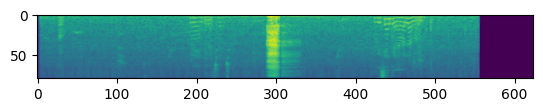

In [106]:
plt.imshow(mel_tgt)

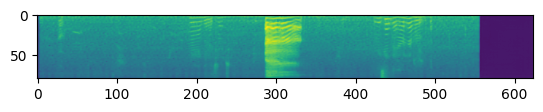

In [107]:
plt.imshow(res)

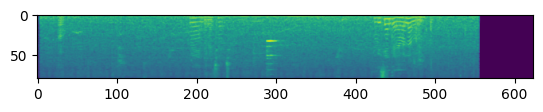

In [108]:
plt.imshow(mel_src)